In [1]:
macro_f1 = 0 
weighted_f1 = 0 

/home/utkarsh/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1236/1236 [00:18<00:00, 66.63it/s]


{'surprise': 0.4906832298136645, 'neutral': 0.7716312056737589, 'disgust': 0.4437689969604863, 'fear': 0.366412213740458, 'sadness': 0.4997455470737913, 'anger': 0.575084175084175, 'joy': 0.5924220963172805, 'overall': 0.6360472472521684}


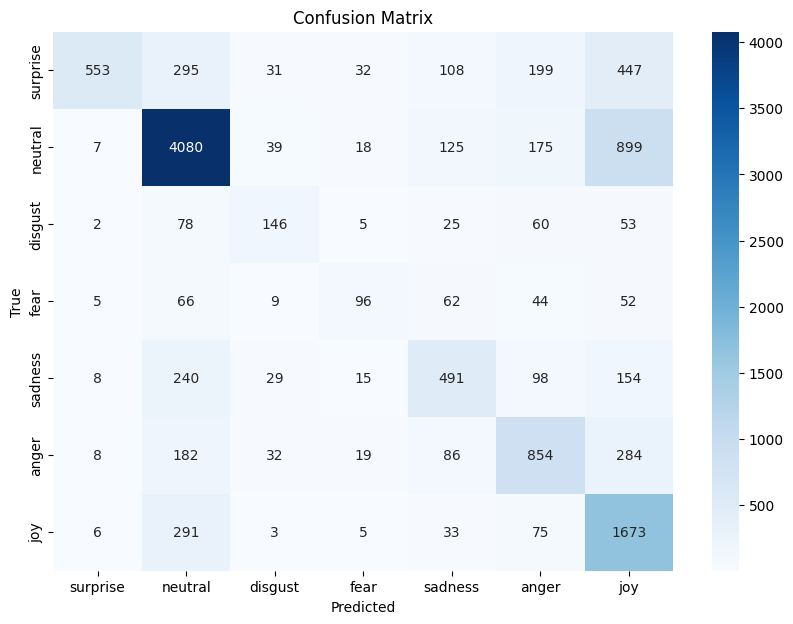

ACCURACY:  0.6418638692363992
PRECISION:  0.6134611777964306
RECALL:  0.5197402708911579


100%|██████████| 138/138 [00:01<00:00, 70.08it/s]


{'surprise': 0.3192488262910798, 'neutral': 0.7688356164383562, 'disgust': 0.39506172839506176, 'fear': 0.41791044776119396, 'sadness': 0.43317972350230416, 'anger': 0.5675675675675674, 'joy': 0.5747508305647842, 'overall': 0.6034078621884279}


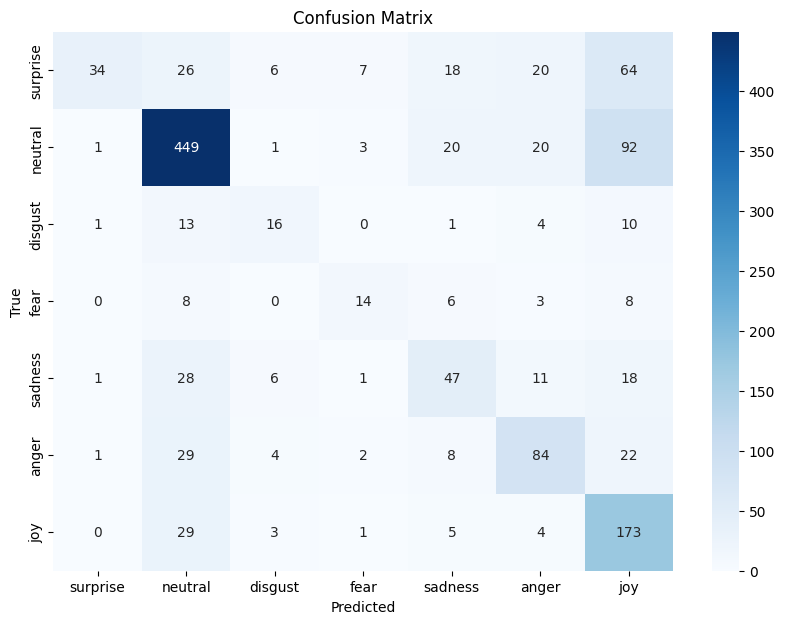

ACCURACY:  0.6180030257186082
PRECISION:  0.58294984098929
RECALL:  0.4941887504063924


{'surprise': 0.3192488262910798,
 'neutral': 0.7688356164383562,
 'disgust': 0.39506172839506176,
 'fear': 0.41791044776119396,
 'sadness': 0.43317972350230416,
 'anger': 0.5675675675675674,
 'joy': 0.5747508305647842,
 'overall': 0.6034078621884279}

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util

import pickle
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# disable CUDNN 

torch.backends.cudnn.enabled = False

import torch
import torch.nn as nn
import torch.nn.functional as F

class ERC_CNN(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, input_size, hidden_size, num_layers, mlp_hidden_size, output_size):
        super(ERC_CNN, self).__init__()
        """
        ERC-CNN Module combining CNN, BiLSTM, and MLP
        Input shape: (batch_size, in_channels, width, length)
        Output shape: (batch_size, seq_length, output_size)
        """
        # CNN layers
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=(1, 1))
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=(1, 1))

        # BiLSTM layer
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        
        # MLP layers
        self.fc1 = nn.Linear(hidden_size * 2, mlp_hidden_size)
        self.fc2 = nn.Linear(mlp_hidden_size, output_size)

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = self.conv2(x)

        # BiLSTM
        x = x.squeeze(1)  # Remove the singleton dimension
        x, _ = self.bilstm(x)

        # MLP
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    

import json

class MyDataset(Dataset):
    def __init__(self, json_path='train_file.json'):
        with open(json_path, 'r') as file:
            self.data = json.load(file)
        self.embedding_model = SentenceTransformer('all-mpnet-base-v2')
        self.emotion_dict = {
            'surprise': 0, 'neutral': 1, 'disgust': 2,
            'fear': 3, 'sadness': 4, 'anger': 5, 'joy': 6
        }

    def generate_cnn_embeddings(self, conversation):
        speakers = [utterance['speaker'] for utterance in conversation]
        texts = [utterance['text'] for utterance in conversation]

        embeddings_list = self.embedding_model.encode(texts)
        
        speaker_index = {}
        for index, speaker in enumerate(speakers):
            if speaker not in speaker_index:
                speaker_index[speaker] = len(speaker_index)
        
        S = len(speaker_index)
        N = len(speakers)
        embeddings_tensor = np.zeros((max(10, S), N, 768))
        for i, (speaker, embedding) in enumerate(zip(speakers, embeddings_list)):
            idx = speaker_index[speaker]
            embeddings_tensor[idx, i, :] = embedding
        return embeddings_tensor

    def gen_emotion_matrix(self, conversation):
        emotions = [utterance['emotion'] for utterance in conversation]
        emotion_matrix = np.zeros((len(emotions), 7))
        for idx, emotion in enumerate(emotions):
            emotion_matrix[idx][self.emotion_dict[emotion]] = 1
        return emotion_matrix

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        conversation = self.data[idx]['conversation']
        X = self.generate_cnn_embeddings(conversation)
        Y = self.gen_emotion_matrix(conversation)
        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

# Define parameters
batch_size = 1
speakers = 10  # max_speakers
num_utterances = 24  # dialogue_length
embedding_size = 768

cnn_mid_channels = 3
cnn_out_channels = 1

hidden_lstm = 64
layers_lstm = 1

inputs_mlp = hidden_lstm * 2
hidden_mlp = 64
output_mlp = number_of_emotions = 7


# Initialize the ERC_CNN class
model = ERC_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                mlp_hidden_size=hidden_mlp,
                output_size=output_mlp)

# set the layer bilstm to not require gradients
# for param in model.bilstm.parameters():
#     param.requires_grad = False

# input_tensor = torch.randn(batch_size, speakers, num_utterances, embedding_size)


import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define your model, loss function, and optimizer
folder_path = "/content/drive/MyDrive/IIITD/Courses/nlp/Assignment 4/"
folder_path = ""

path_train_file = folder_path+"train_file.json"

dataset = MyDataset(path_train_file)
criterion = nn.CrossEntropyLoss().to(DEVICE)

model = ERC_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                mlp_hidden_size=hidden_mlp,
                output_size=output_mlp).to(DEVICE)

for param in model.bilstm.parameters():
    param.requires_grad = False

optimizer = optim.Adam(model.parameters(), lr=0.001)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

val_dataset = MyDataset(folder_path+"val_file.json")
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

train_losses = []
val_losses = []

# if the model is already trained, load the model
if os.path.exists(folder_path+"M1.pth"):
    model.load_state_dict(torch.load(folder_path+"M1.pth"))



import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ERC_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                mlp_hidden_size=hidden_mlp,
                output_size=output_mlp)

state_dict = torch.load('M1.pth')
model.load_state_dict(state_dict)

model = model.to(DEVICE)

l = ['surprise', 'neutral', 'disgust', 'fear', 'sadness', 'anger', 'joy']

model.eval()


import torch
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def get_F1(model , dataloader , DEVICE):
    all_predicted=[]
    all_true=[]

    for inputs,labels in tqdm(dataloader):
        inputs=inputs.to(DEVICE)
        labels=labels.to(DEVICE)
        with torch.no_grad():
            outputs=model(inputs.float())
        predicted=torch.argmax(outputs,dim=2).cpu().numpy().flatten()
        true_labels=torch.argmax(labels,dim=2).cpu().numpy().flatten()
        all_predicted.extend(predicted)
        all_true.extend(true_labels)

    f1_scores_dict = {
        'surprise': f1_score(all_true, all_predicted, labels=[0], average='weighted'),
        'neutral': f1_score(all_true, all_predicted, labels=[1], average='weighted'),
        'disgust': f1_score(all_true, all_predicted, labels=[2], average='weighted'),
        'fear': f1_score(all_true, all_predicted, labels=[3], average='weighted'),
        'sadness': f1_score(all_true, all_predicted, labels=[4], average='weighted'),
        'anger': f1_score(all_true, all_predicted, labels=[5], average='weighted'),
        'joy': f1_score(all_true, all_predicted, labels=[6], average='weighted'),
        'overall': f1_score(all_true, all_predicted, average='weighted')
    }    

    global macro_f1 , weighted_f1

    macro_f1 = f1_score(all_true, all_predicted, average='macro')
    weighted_f1 = f1_score(all_true, all_predicted, average='weighted')

    cm = confusion_matrix(all_true, all_predicted)

    print(f1_scores_dict)

    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=l, yticklabels=l)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    from sklearn.metrics import accuracy_score , precision_score , recall_score
    acc = accuracy_score(all_true, all_predicted)
    p = precision_score(all_true, all_predicted, average='macro')
    r = recall_score(all_true, all_predicted, average='macro')
    print("ACCURACY: ", acc)
    print("PRECISION: " , p)
    print("RECALL: " , r)

    return f1_scores_dict , acc , p , r

# TRAINING 
dataset = MyDataset("train_file.json")
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

train_f1 , acc_train , precision_train , recall_train = get_F1(model , dataloader , DEVICE)

train_f1


# VALIDATION
val_dataset = MyDataset("val_file.json")
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_f1  , acc_val , precision_val , recall_val = get_F1(model , val_dataloader , DEVICE)

test_f1 

In [3]:
print("WEIGHTED F1: ", weighted_f1)

WEIGHTED F1:  0.6034078621884279


In [4]:
print("MACRO F1: ", macro_f1)

MACRO F1:  0.49665067721719247


In [5]:
print("Imbalance proof F1 (our metric): ", np.sqrt(((weighted_f1**2 + macro_f1**2) / 2)))

Imbalance proof F1 (our metric):  0.5526133111548729
